# Finite Strain 
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/finite_strain.ipynb)

We compare small-strain and finite-strain material models for a cantilever beam subjected to a concentrated force at its tip.

In [1]:
import torch
import pyvista
import matplotlib.pyplot as plt

from torchfem import Solid
from torchfem.mesh import cube_hexa
from torchfem.materials import (
    IsotropicElasticity3D,
    IsotropicSaintVenantKirchhoff3D,
    NeoHookean3D,
)

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

# Generate beam
L = 5.0
nodes, elements = cube_hexa(21, 5, 5, L, 1.0, 1.0)

# Define load
P = -5.0
tip = (nodes[:, 0] == L) & (nodes[:, 1] == 0.5) & (nodes[:, 2] == 0.5)

# Increments
t_abq = torch.linspace(0.0, 1.0, 11)
increments = torch.linspace(0.0, 1.0, 11)

## Small strain isotropic elasticity 

In [2]:
material = IsotropicElasticity3D(E=1000.0, nu=0.3)
beam1 = Solid(nodes, elements, material)

# Assign boundary conditions
beam1.constraints[nodes[:, 0] == 0, :] = True
beam1.forces[tip, 2] = P

# Solve
u1, f1, σ1, F1, α1 = beam1.solve(increments=increments, return_intermediate=True)

In [3]:
# Show result
beam1.plot(u=u1[-1], element_property={"Stress": σ1[-1, :, 0, 0]}, show_undeformed=True)
print(f"Maximum stress σ_xx: {σ1[-1,:,0,0].max():.3f} (112.96)")
print(f"Maximum stress σ_xx: {σ1[-1,:,0,0].min():.3f} (-112.96)")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

Maximum stress σ_xx: 108.787 (112.96)
Maximum stress σ_xx: -108.787 (-112.96)


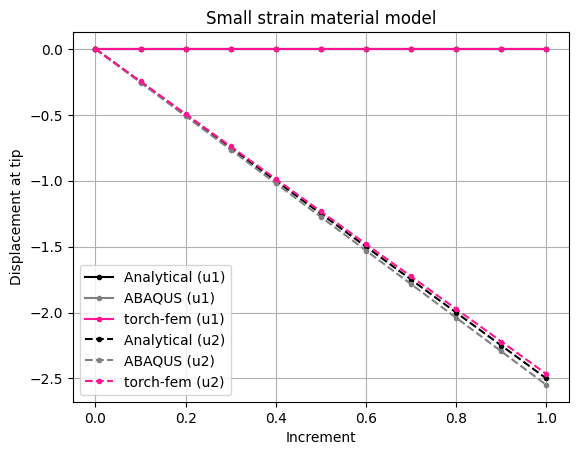

In [4]:
u1_abq = torch.tensor(
    [
        [0.00e-09, 0, -0.00000],
        [3.16e-09, 0, -0.25489],
        [6.32e-09, 0, -0.50978],
        [9.48e-09, 0, -0.76467],
        [1.26e-08, 0, -1.01956],
        [1.58e-08, 0, -1.27445],
        [1.90e-08, 0, -1.52934],
        [2.21e-08, 0, -1.78423],
        [2.53e-08, 0, -2.03912],
        [2.84e-08, 0, -2.29401],
        [3.16e-08, 0, -2.54890],
    ]
)
u1_ref = torch.zeros((len(t_abq), 3))
u1_ref[:, 2] = 4.0 * L**3 / 1000.0 * P * t_abq


# Plot
plt.plot(t_abq, u1_ref[:, 0], ".-", color="black", label="Analytical (u1)")
plt.plot(t_abq, u1_abq[:, 0], ".-", color="gray", label="ABAQUS (u1)")
plt.plot(increments, u1[:, tip, 0], ".-", color="deeppink", label="torch-fem (u1)")
plt.plot(t_abq, u1_ref[:, 2], ".--", color="black", label="Analytical (u2)")
plt.plot(t_abq, u1_abq[:, 2], ".--", color="gray", label="ABAQUS (u2)")
plt.plot(increments, u1[:, tip, 2], ".--", color="deeppink", label="torch-fem (u2)")
plt.xlabel("Increment")
plt.ylabel("Displacement at tip")
plt.title("Small strain material model")
plt.legend()
plt.grid()
plt.show()

## Isotropic Stain Venant-Kirchhoff

In [5]:
# Create model with Kirchhoff material
material = IsotropicSaintVenantKirchhoff3D(E=1000.0, nu=0.3)
beam2 = Solid(nodes, elements, material)

# Assign boundary conditions
beam2.constraints[nodes[:, 0] == 0, :] = True
beam2.forces[tip, 2] = P

# Solve
u2, f2, S2, F2, α2 = beam2.solve(
    increments=increments, max_iter=100, return_intermediate=True
)

# Compute Cauchy stress from 2nd Piola-Kirchhoff stress
J2 = torch.det(F2)[..., None, None]
σ2 = F2 @ S2 @ F2.transpose(-1, -2) / J2

In [6]:
# Show result
beam2.plot(u=u2[-1], element_property={"Stress": σ2[-1, :, 0, 0]}, show_undeformed=True)
print(f"Maximum stress σ_xx: {σ2[-1,:,0,0].max():.3f} (  97.325)")
print(f"Minimum stress σ_xx: {σ2[-1, :,0,0].min():.3f} (-104.776)")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

Maximum stress σ_xx: 137.051 (  97.325)
Minimum stress σ_xx: -86.856 (-104.776)


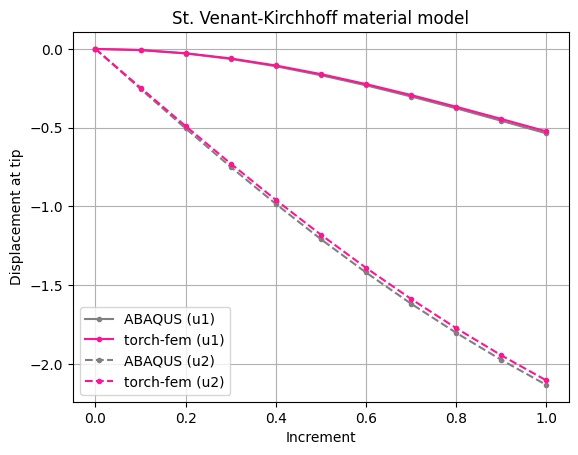

In [7]:
u2_abq = torch.tensor(
    [
        [-0.00e-03, 0, -0.00000],
        [-7.49e-03, 0, -0.25409],
        [-2.91e-02, 0, -0.50474],
        [-6.38e-02, 0, -0.74882],
        [-1.10e-01, 0, -0.98373],
        [-1.67e-01, 0, -1.20750],
        [-2.31e-01, 0, -1.41880],
        [-3.02e-01, 0, -1.61694],
        [-3.77e-01, 0, -1.80173],
        [-4.56e-01, 0, -1.97340],
        [-5.36e-01, 0, -2.13246],
    ]
)


# Plot
plt.plot(t_abq, u2_abq[:, 0], ".-", color="gray", label="ABAQUS (u1)")
plt.plot(increments, u2[:, tip, 0], ".-", color="deeppink", label="torch-fem (u1)")
plt.plot(t_abq, u2_abq[:, 2], ".--", color="gray", label="ABAQUS (u2)")
plt.plot(increments, u2[:, tip, 2], ".--", color="deeppink", label="torch-fem (u2)")
plt.xlabel("Increment")
plt.ylabel("Displacement at tip")
plt.title("St. Venant-Kirchhoff material model")
plt.legend()
plt.grid()
plt.show()

## Neo-Hookean 

In [8]:
# Create model with Neo-Hookean material
material = NeoHookean3D(lbd0=576.9231, mu0=384.6154)
# print(f"C10: {material.mu0/2}")
# print(f"D1: {2/(material.lbd0+2/3*material.mu0)}")
beam3 = Solid(nodes, elements, material)

# Assign boundary conditions
beam3.constraints[nodes[:, 0] == 0, :] = True
beam3.forces[tip, 2] = P

# Solve
u3, f3, S3, F3, α3 = beam3.solve(
    increments=increments, max_iter=100, return_intermediate=True
)

# Compute Cauchy stress from 2nd Piola-Kirchhoff stress
J3 = torch.det(F3)[..., None, None]
σ3 = F3 @ S3 @ F3.transpose(-1, -2) / J3

In [9]:
# Show result
beam3.plot(u=u3[-1], element_property={"Stress": σ3[-1, :, 0, 0]}, show_undeformed=True)
print(f"Maximum stress σ_xx: {σ3[-1,:,0,0].max():.3f} ( 97.937)")
print(f"Minimum stress σ_xx: {σ3[-1, :,0,0].min():.3f} (-98.494)")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

Maximum stress σ_xx: 125.211 ( 97.937)
Minimum stress σ_xx: -97.801 (-98.494)


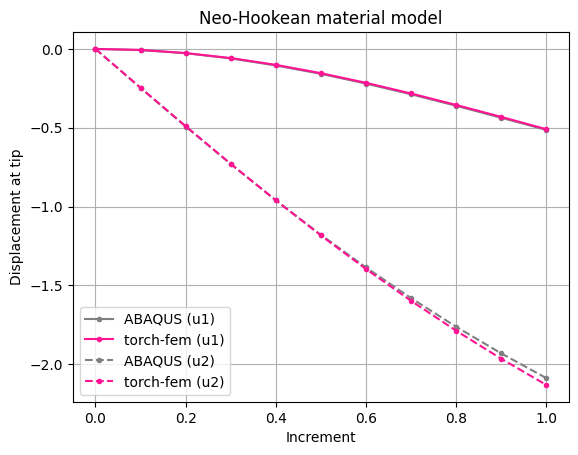

In [10]:
u3_abq = torch.tensor(
    [
        [-0.00e-03, 0, -0.00000],
        [-6.89e-03, 0, -0.24780],
        [-2.73e-02, 0, -0.49240],
        [-6.03e-02, 0, -0.73081],
        [-1.05e-01, 0, -0.96052],
        [-1.58e-01, 0, -1.17962],
        [-2.20e-01, 0, -1.38682],
        [-2.88e-01, 0, -1.58139],
        [-3.61e-01, 0, -1.76314],
        [-4.37e-01, 0, -1.93224],
        [-5.14e-01, 0, -2.08913],
    ]
)


# Plot
plt.plot(t_abq, u3_abq[:, 0], ".-", color="gray", label="ABAQUS (u1)")
plt.plot(increments, u3[:, tip, 0], ".-", color="deeppink", label="torch-fem (u1)")
plt.plot(t_abq, u3_abq[:, 2], ".--", color="gray", label="ABAQUS (u2)")
plt.plot(increments, u3[:, tip, 2], ".--", color="deeppink", label="torch-fem (u2)")
plt.xlabel("Increment")
plt.ylabel("Displacement at tip")
plt.title("Neo-Hookean material model")
plt.legend()
plt.grid()
plt.show()

## Comparison

In [11]:
plotter = pyvista.Plotter()
beam1.plot(color="gray", plotter=plotter, opacity=0.1)
beam1.plot(u=u1[-1], color="cyan", opacity=0.8, plotter=plotter)
beam2.plot(u=u2[-1], color="orange", opacity=0.8, plotter=plotter)
beam3.plot(u=u3[-1], color="red", opacity=0.8, plotter=plotter)
plotter.show(jupyter_backend="html")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…